### Imports & Miscellaneous Functions

In [1]:
!pip install gym
import cv2, os, time, sys, copy
import numpy as np
from gym import spaces, Env
import matplotlib.pyplot as plt

cwd = os.path.join('..', 'forest_env')
os.chdir(cwd)
from forest import Forest

In [2]:
# function for plotting towards the end of the notebook
# inputs - algo - function handle, algorithm to be used
#        - stoh - whether or not stohchasticity is introduced in the environment
#        - name - string, name of the algorithm
#        - eps - epsilon value
#        - gamma - discount factor
#        - alpha - learning rate
#        - episodes - number of episodes to run
#        - iterations - number of times to run the agent training
#        - fit - whether or not to fit a line to the points
# outputs - None
def graph_rewards_and_epsilon(algo, name, stoh=False, eps=.9, gamma=.8, alpha=.2, num_episodes=1000, iterations=20, fit=True):
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        environment.set_stoh(stoh)
        for i in np.arange(iterations):
            agent = algo(environment, 
                            epsilon=eps,
                            gamma=gamma,
                            alpha=alpha,
                            episodes=num_episodes)
            episodes = np.arange(agent.episodes)
            if fit:
                coeff = np.polyfit(episodes, agent.rewards, 10)

                x = np.linspace(0, num_episodes, num_episodes)
                y = np.poly1d(coeff)(episodes)

                ax1.plot(x, y)
            else:
                ax1.plot(episodes, agent.rewards)

        ax1.set_title('Cumulative Rewards per Episode in %s' % name, size=15)
        ax1.set_ylabel('Cumulative Reward', fontsize=15)
        ax1.set_xlabel('Episode', fontsize=15)
        ax1.set_ylim(-1.5, 1.5)
        ax1.tick_params(labelsize=15)

        ax2.plot(episodes, agent.epsilons)
        ax2.set_title('Epsilon Decay Throughout Episodes', size=15)
        ax2.set_ylabel('Epsilon', fontsize=15)
        ax2.set_xlabel('Episode', fontsize=15);
        ax2.tick_params(labelsize=15)

        return 

### Grid Environment

loading images.. DONE.
drawing initial environment.. DONE.


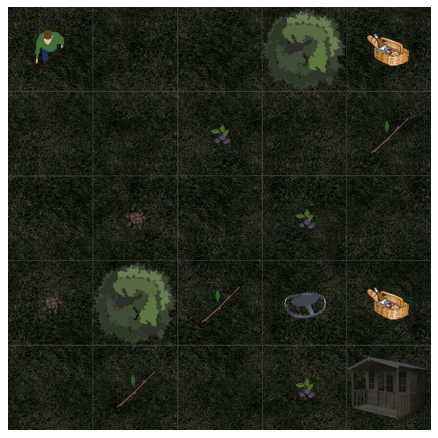

In [3]:
# initialize the environment
environment = Forest(one_hot_encoding=False)
environment.reset()
environment.render();

### Q-Learning Based Agent

In [4]:
class QLearningAgent():
    # function that initializes q-learning agent
    # inputs - env - Environment the agent is acting upon
    #        - epsilon - eps-greedy factor
    #        - gamma - discount factor
    #        - alpha - step size
    #        - episodes - number of runs the agent will take
    def __init__(self, env=None, epsilon=.9, gamma=.75, alpha=0.2, episodes=500):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space

        self.init_epsilon = epsilon
        self.epsilon = self.init_epsilon
        self.gamma = gamma
        self.alpha = alpha
        self.episodes = episodes

        self.calculate_q_table()


    # function that calculates the q-table
    # inputs - None
    # outputs - None
    def calculate_q_table(self):
        q_table = np.zeros((self.observation_space.n, self.action_space.n))
        epsilons = []
        rewards = []

        for episode in range(self.episodes):
            cumulative_reward, done = 0, False
            state = self.env.reset()
            while not done:
                action = self.__step__(state, q_table)
                next_state, reward, done, info = self.env.step(action)
                next_action = np.where(q_table[next_state] == max(q_table[next_state]))[0][0]
                q_table[state][action] += self.alpha * (reward + self.gamma * q_table[next_state][next_action] - q_table[state][action])
                
                state = next_state
                cumulative_reward += reward
        
            self.epsilon = self.init_epsilon * np.exp(-episode/(self.episodes/4))
            epsilons.append(self.epsilon)
            rewards.append(cumulative_reward)
        self.q_table = q_table
        self.epsilons = epsilons
        self.rewards = rewards
        
        return q_table, epsilons, rewards, self.episodes


    # function that picks the next step based on e-greedy 
    # inputs - observation - the current location of the agent
    #        - q-table - the table of Q values
    # outputs - an action
    def __step__(self, state, q_table):
        roll = np.random.uniform()
        if roll < self.epsilon:   # pick random action
            action = np.random.choice(self.action_space.n)
        
        else: # pick greedy action 
            action = np.where(q_table[state] == max(q_table[state]))[0][0]
        return action


    # function that takes steps once the final Q-table generation is done
    # inputs - observation - (x, y), current position of the agent
    # outputs - optimal action
    def step(self, state):
        return np.where(self.q_table[state] == max(self.q_table[state]))[0][0]


#### Deterministic

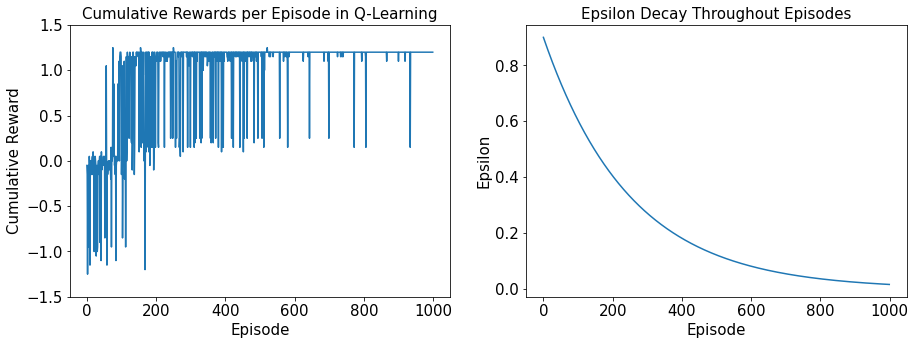

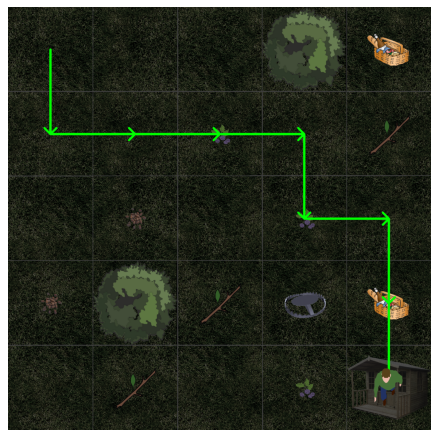

In [5]:
# run single for visualization
graph_rewards_and_epsilon(QLearningAgent,
                          'Q-Learning',
                          stoh=False,
                          eps=.9,
                          gamma=.8,
                          alpha=.2,
                          num_episodes=1000,
                          iterations=1,
                          fit=False)

environment.render();

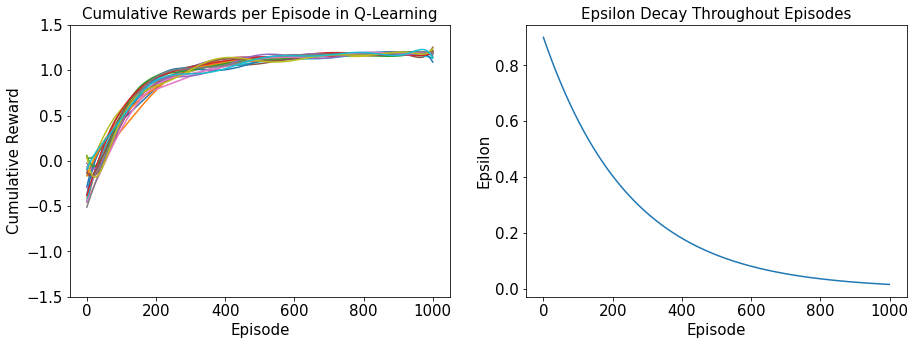

In [6]:
# run multiple to check performance
graph_rewards_and_epsilon(QLearningAgent,
                          'Q-Learning',
                          stoh=False,
                          eps=.9,
                          gamma=.8,
                          alpha=.2,
                          num_episodes=1000,
                          iterations=20,
                          fit=True)

#### Stochastic

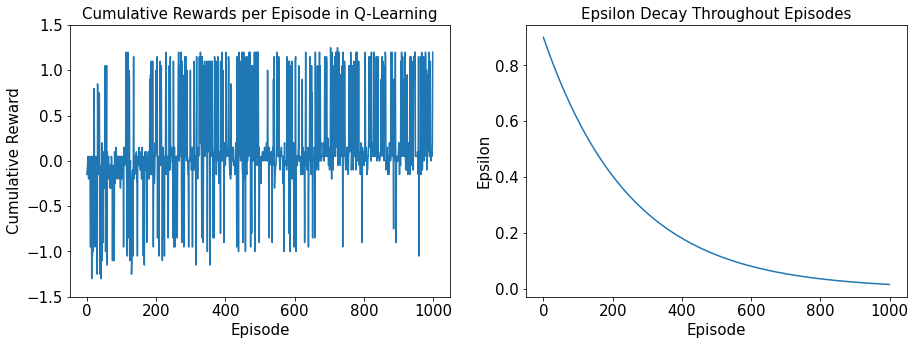

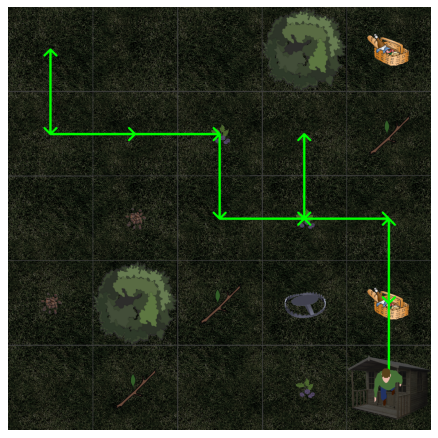

In [7]:
# run single for visualization
graph_rewards_and_epsilon(QLearningAgent,
                          'Q-Learning',
                          stoh=True,
                          eps=.9,
                          gamma=.8,
                          alpha=.2,
                          num_episodes=1000,
                          iterations=1,
                          fit=False)
environment.render();

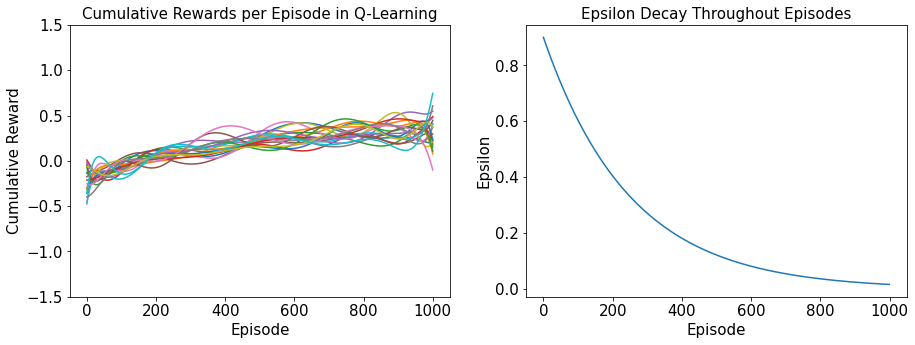

In [8]:
graph_rewards_and_epsilon(QLearningAgent,
                          'Q-Learning',
                          stoh=True,
                          eps=.9,
                          gamma=.8,
                          alpha=.2,
                          num_episodes=1000,
                          iterations=20,
                          fit=True)

### SARSA Based Agent

In [9]:
class SARSAAgent():
    # function that initializes q-learning agent
    # inputs - env - Environment the agent is acting upon
    #        - epsilon - eps-greedy factor
    #        - gamma - discount factor
    #        - alpha - step size
    #        - episodes - number of runs the agent will take
    def __init__(self, env=None, epsilon=.9, gamma=.8, alpha=0.2, episodes=500):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space

        self.init_epsilon = epsilon
        self.epsilon = self.init_epsilon
        self.gamma = gamma
        self.alpha = alpha
        self.episodes = episodes

        self.calculate_q_table()

    # function that calculates the q-table
    # inputs - None
    # outputs - None
    def calculate_q_table(self):
        q_table = np.zeros((self.observation_space.n, self.action_space.n))
        epsilons = []
        rewards = []

        for episode in range(self.episodes):
            cumulative_reward, done = 0, False
            
            state = self.env.reset()
            action = self.__step__(state, q_table)
            
            while not done:
                next_state, reward, done, info = self.env.step(action)
                next_action = self.__step__(next_state, q_table)
                q_table[state][action] += self.alpha * (reward + self.gamma * q_table[next_state][next_action] - q_table[state][action])
                
                state = next_state
                action = next_action
                cumulative_reward += reward
                
            self.epsilon = self.init_epsilon * np.exp(episode/(-self.episodes/4))
            epsilons.append(self.epsilon)
            rewards.append(cumulative_reward)

        self.q_table = q_table
        self.epsilons = epsilons
        self.rewards = rewards
        return q_table, epsilons, rewards, self.episodes


    # function that picks the next step based on e-greedy 
    # inputs - observation - the current location of the agent
    #        - q-table - the table of Q values
    # outputs - an action
    def __step__(self, state, q_table):
        roll = np.random.uniform()
        if roll < self.epsilon:   # pick random action
            action = np.random.choice(self.action_space.n)
        
        else: # pick greedy action 
            action = np.where(q_table[state] == max(q_table[state]))[0][0]
        return action


    def step(self, state):
        return np.where(self.q_table[state] == max(self.q_table[state]))[0][0]


#### Deterministic

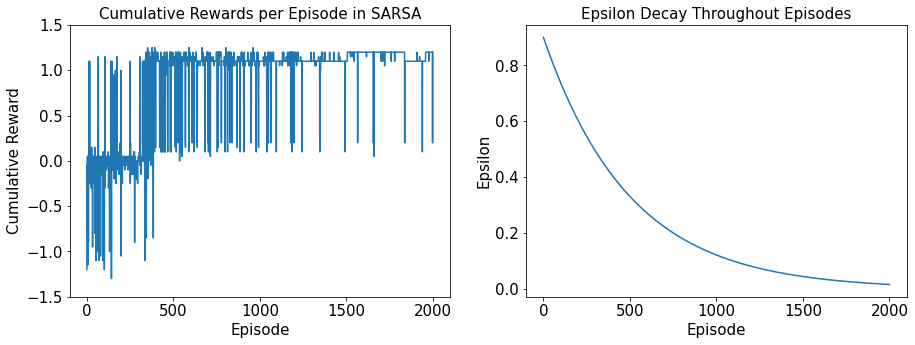

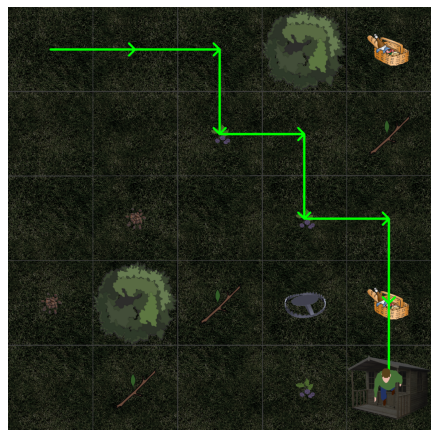

In [10]:
graph_rewards_and_epsilon(SARSAAgent,
                          'SARSA',
                          stoh=False,
                          eps=.9,
                          gamma=.8,
                          alpha=.2,
                          num_episodes=2000,
                          iterations=1,
                          fit=False)
environment.render();

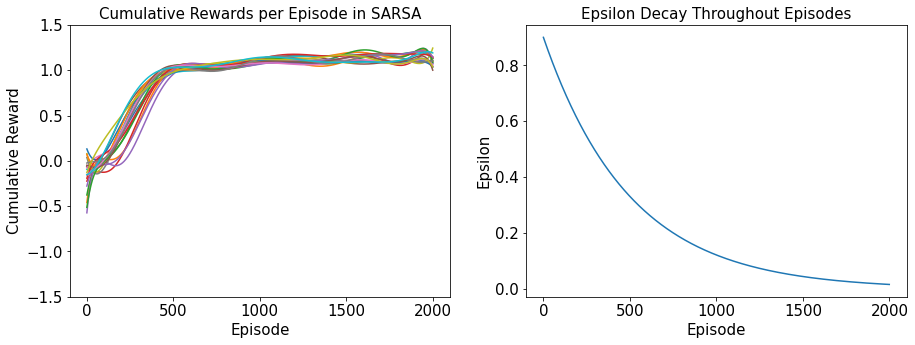

In [11]:
graph_rewards_and_epsilon(SARSAAgent,
                          'SARSA',
                          stoh=False,
                          eps=.9,
                          gamma=.8,
                          alpha=.2,
                          num_episodes=2000,
                          iterations=20,
                          fit=True)

#### Stohchastic

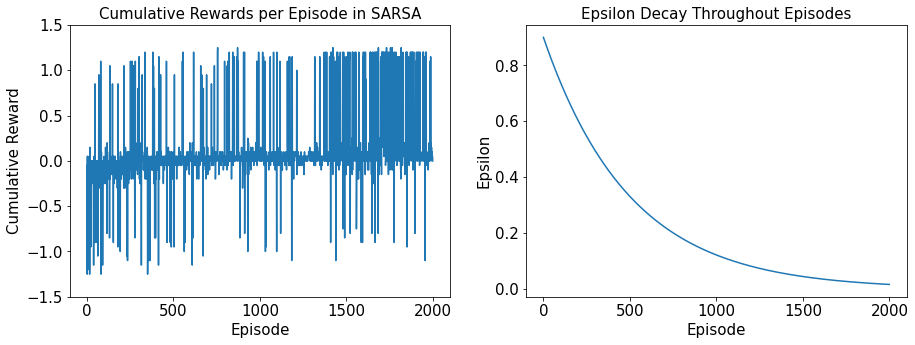

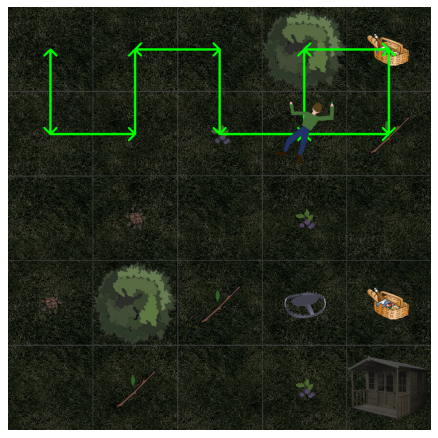

In [12]:
graph_rewards_and_epsilon(SARSAAgent,
                          'SARSA',
                          stoh=True,
                          eps=.9,
                          gamma=.8,
                          alpha=.2,
                          num_episodes=2000,
                          iterations=1, 
                          fit=False)
environment.render();

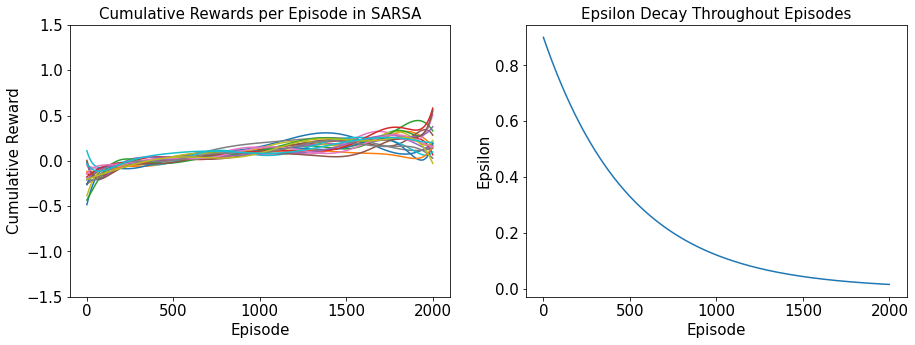

In [13]:
graph_rewards_and_epsilon(SARSAAgent,
                          'SARSA',
                          stoh=True,
                          eps=.9,
                          gamma=.8,
                          alpha=.2,
                          num_episodes=2000,
                          iterations=20, 

                          fit=True)

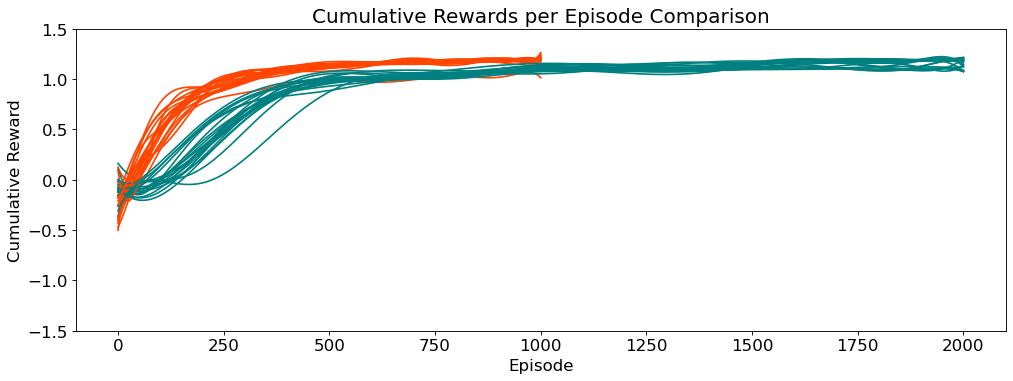

In [14]:
plt.rcParams.update({'font.size': 15})
plt.figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')

environment.set_stoh(False)
for i in range(20):
    environment.reset()
    agent = QLearningAgent(environment, 
                epsilon=.9,
                gamma=.8,
                alpha=.2,
                episodes=1000)

    episodes = np.arange(agent.episodes)
    coeff = np.polyfit(episodes, agent.rewards, 10)

    x = np.linspace(0, 1000, 1000)
    y = np.poly1d(coeff)(episodes)

    plt.plot(x, y, color='orangered')

    environment.reset()
    agent = SARSAAgent(environment, 
                epsilon=.9,
                gamma=.8,
                alpha=.2,
                episodes=2000)

    episodes = np.arange(agent.episodes)
    coeff = np.polyfit(episodes, agent.rewards, 10)

    x = np.linspace(0, 2000, 2000)
    y = np.poly1d(coeff)(episodes)

    plt.plot(x, y, color='teal')

plt.title('Cumulative Rewards per Episode Comparison')
plt.ylabel('Cumulative Reward')
plt.xlabel('Episode')
plt.ylim(-1.5, 1.5)

plt.show()

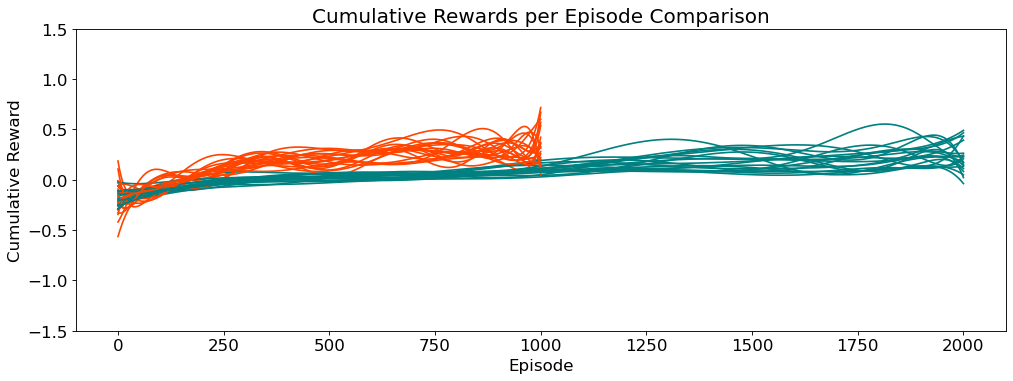

In [15]:

plt.rcParams.update({'font.size': 15})
plt.figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')

environment.set_stoh(True)
for i in range(20):
    environment.reset()
    agent = QLearningAgent(environment, 
                epsilon=.9,
                gamma=.8,
                alpha=.2,
                episodes=1000)

    episodes = np.arange(agent.episodes)
    coeff = np.polyfit(episodes, agent.rewards, 10)

    x = np.linspace(0, 1000, 1000)
    y = np.poly1d(coeff)(episodes)

    plt.plot(x, y, color='orangered')

    environment.reset()
    agent = SARSAAgent(environment, 
                epsilon=.9,
                gamma=.8,
                alpha=.2,
                episodes=2000)

    episodes = np.arange(agent.episodes)
    coeff = np.polyfit(episodes, agent.rewards, 10)

    x = np.linspace(0, 2000, 2000)
    y = np.poly1d(coeff)(episodes)

    plt.plot(x, y, color='teal')

plt.title('Cumulative Rewards per Episode Comparison')
plt.ylabel('Cumulative Reward')
plt.xlabel('Episode')
plt.ylim(-1.5, 1.5)

plt.show()

<ipython-input-16-01546322e5d1>:44: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


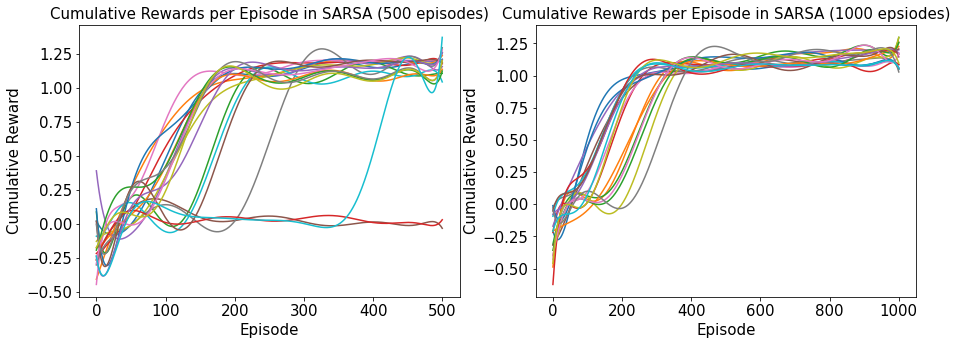

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
for v in np.arange(20):
    environment.set_stoh(False)
    agent = SARSAAgent(environment, 
                    epsilon=.9,
                    gamma=.75,
                    alpha=.2,
                    episodes=500)

    episodes = np.arange(agent.episodes)
    
    coeff = np.polyfit(episodes, agent.rewards, 10)

    x = np.linspace(0, agent.episodes, agent.episodes)
    y = np.poly1d(coeff)(episodes)

    ax1.plot(x, y)

for v in np.arange(20):
    environment.set_stoh(False)
    agent = SARSAAgent(environment, 
                    epsilon=.9,
                    gamma=.75,
                    alpha=.2,
                    episodes=1000)

    episodes = np.arange(agent.episodes)
    
    coeff = np.polyfit(episodes, agent.rewards, 10)

    x = np.linspace(0, agent.episodes, agent.episodes)
    y = np.poly1d(coeff)(episodes)

    ax2.plot(x, y)
    
ax1.set_title('Cumulative Rewards per Episode in SARSA (500 episodes)', size=15)
ax1.set_ylabel('Cumulative Reward', fontsize=15)
ax1.set_xlabel('Episode', fontsize=15)
ax1.tick_params(labelsize=15)
ax2.set_title('Cumulative Rewards per Episode in SARSA (1000 epsiodes)', size=15)
ax2.set_ylabel('Cumulative Reward', fontsize=15)
ax2.set_xlabel('Episode', fontsize=15)
ax2.tick_params(labelsize=15)
f.show()